# Section 07: Applications in single-cell data analaysis

- Author: Zijun Wu

---

In this tutorial, we will walk through several fundamental methods from scikit-bio that are generally useful in various "omics" fields, such as single-cell RNA sequencing (**scRNA-seq**) data analysis. Aside from the standard libraries specialized for single-cell data such as [Scanpy](https://scanpy.readthedocs.io/en/stable/) and [Seurat](https://satijalab.org/seurat/), scikit-bio provides a powerful suite of complementary functions that borrow insights from microbiome analysis to enrich single-cell studies into new analytical dimensions.

## Introduction

The analysis of complex, high-dimensional single-cell data relies on multivariate statistical methods to uncover meaningful biological patterns. A key initial step in exploring this data involves visualizing the relationships between samples (cells), accomplished through dimensionality reduction methods including PCA, UMAP, and scikit-bio's **PCoA** method. A notable feature of PCoA is its capacity to preserve linear relationships from any dissimilarity matrix. This inherent flexibility is particularly advantageous for the nuanced analysis of noisy and sparse single-cell data. To move beyond visualization and statistically validate the observed patterns, we will use **PERMANOVA** that assesses the correlation between samples. In addition, we will apply **Mantel test** that measures the association between two distinct distance matrices, such as those generated from different cell types. Another challenge of single-cell study is the compositionality of the data, as it introduces analytical bias that can lead to the spurious identification of true changes in gene expression. To overcome this issue, we will use variance log ratio (**VLR**) to quantify the dissimilarity between genes. Furthermore, we will perform the compositionality-aware **Dirmult t-test** to identify the differentially expressed genes between cell types, which provide extra insights into the discovery of cell type-specific marker genes.

## Preparation

Install the latest version of scikit-bio.

In [1]:
from importlib.util import find_spec

In [2]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [3]:
import skbio
skbio.__version__

'0.7.0'

We will also install Scanpy, *the* Python library for single-cell data analysis. Such that we can demonstrate how scikit-bio can work alongside Scanpy to complement its functions.

In [4]:
if find_spec('scanpy') is None:
    !pip install -q scanpy

In [5]:
import scanpy as sc

Import common libraries.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## scRNA-seq data

This tutorial will use a human brain scRNA-seq dataset for demonstration. It consists of 22,085 genes by 420 cells, grouped into 8 cell types. It was described in:

- Darmanis S, Sloan SA, Zhang Y, Enge M, Caneda C, Shuer LM, Hayden Gephart MG, Barres BA, Quake SR. [A survey of human brain transcriptome diversity at the single cell level.](https://www.pnas.org/doi/full/10.1073/pnas.1507125112) _Proceedings of the National Academy of Sciences_. 2015 Jun 9;112(23):7285-90.

Download the data files. If the following commands don't work, download them manually from [here](https://github.com/scikit-bio/scikit-bio-tutorials/tree/main/07-single-cell-omics/data).

In [7]:
!wget -q "https://raw.githubusercontent.com/scikit-bio/scikit-bio-tutorials/main/07-single-cell-omics/data/tags.csv.gz"

In [8]:
!wget -q "https://raw.githubusercontent.com/scikit-bio/scikit-bio-tutorials/main/07-single-cell-omics/data/cidr.csv.gz"

In [9]:
!wget -q "https://raw.githubusercontent.com/scikit-bio/scikit-bio-tutorials/main/07-single-cell-omics/data/ct.csv"

In [10]:
!gunzip tags.csv.gz cidr.csv.gz

Load the scRNA-seq data table. It is a count matrix of samples (rows) by features (columns). Cell values are non-negative integers, representing the number of sequencing reads assigned to each feature in each sample. This pattern is shared across multiple omics, whereas the meanings of samples and features could differ. In the current dataset, samples are **cells** and features are **genes**.

In [11]:
df = pd.read_csv('tags.csv', index_col=0).T
df.head()

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
GSM1658365,0,0,0,0,0,0,0,0,0,0,...,0,28,0,5,0,67,9,0,0,0
GSM1658366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,22,0,0,6,0,7,0
GSM1658364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GSM1658363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,18,0,0,0,0,4,0
GSM1658362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0


scRNA-seq data shares some common statistical properties as other omic data types, such as **sparsity** (a large proportion of cell values are zero).

In [12]:
np.count_nonzero(df) / np.multiply(*df.shape)

np.float64(0.18597324191166165)

And the **skewed distribution** of data.

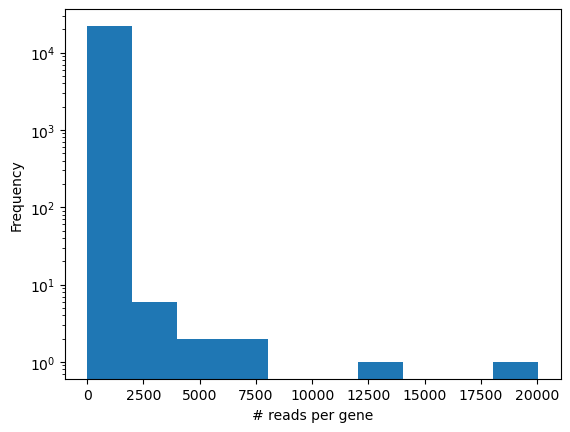

In [13]:
plt.hist(df.iloc[0], log=True)
plt.xlabel('# reads per gene')
plt.ylabel('Frequency');

Load cell type labels (sample metadata).

In [14]:
ct = pd.read_csv('ct.csv', index_col=0)
ct.head()

,cell_type
GSM1658365,fetal_quiescent
GSM1658366,fetal_quiescent
GSM1658364,fetal_quiescent
GSM1658363,fetal_quiescent
GSM1658362,fetal_quiescent


In a typical single-cell analysis workflow, cell type identities are assigned to unlabeled clusters by matching expression patterns with a set of canonical marker genes or by using the top differentially expressed genes to infer the cell type of a cluster. The dataset used in this tutorial was already annotated.

In [15]:
ct.value_counts()

cell_type        
neurons              131
fetal_quiescent      110
astrocytes            62
oligodendrocytes      38
fetal_replicating     25
endothelial           20
OPC                   18
microglia             16
Name: count, dtype: int64

Confirm that the data table and the cell type labels contain the same sample IDs.

In [16]:
ct.index.identical(df.index)

True

## Basic workflow

Here we will demonstrate a typical scRNA-seq analysis workflow using Scanpy. First, the data table and metadata (cell types) will be read into an [AnnData](https://anndata.readthedocs.io/en/stable/) object, a widely adopted format in single-cell omics. The AnnData package should have been installed along with Scanpy already.

In [17]:
import anndata as ad

In [18]:
adata = ad.AnnData(df, obs=ct)
adata

AnnData object with n_obs × n_vars = 420 × 22085
    obs: 'cell_type'

In the AnnData nomenclature, samples are referred to as "**observations**" (`obs`) and features as "**variables**" (`var`).

We will perform the typical preprocessing steps recommended in the [Scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/index.html). The procedures involve filtering, normalization, log-transformation, feature selection, and dimensionality reduction using PCA (Principal Component Analysis)

In [19]:
# preprocessing to filter cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
# median count depth normalization
sc.pp.normalize_total(adata)
# log plus one transformation
sc.pp.log1p(adata)

In [20]:
# feature selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# dimension reduction using pca
sc.pp.pca(adata)

Generate a PCA plot to quickly preview the clustering pattern of data, and how it matches the cell type labels.

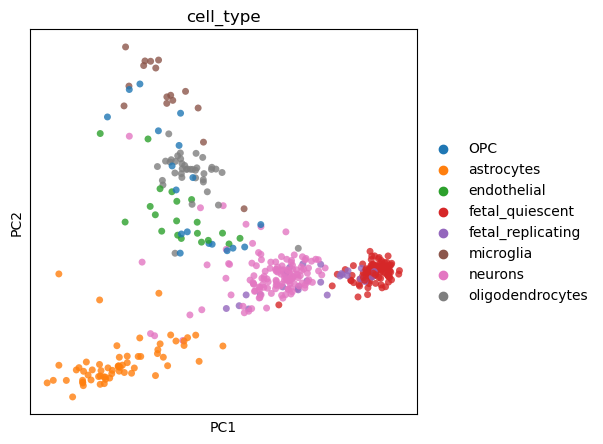

In [21]:
plt.figure(figsize=(5, 5))
sc.pl.pca(adata, color='cell_type', size=100, alpha=0.8, ax=plt.gca())

Our first attempt to visualize cell clustering in PC coordinates revealed poor separation among most of the cell populations. The resulting clusters were largely overlapping, suggesting that the linear assumptions of PCA were insufficient to capture the underlying biological structure of the dataset.

Therefore, we will compute the neighborhood graph of cells from PCA and visualize the embeding of the neighborhood graph into the UMAP (Uniform Manifold Approximation and Projection) space. The UMAP plot provided a much clearer and more distinct clustering, which enables the subsequent cell type identification and analysis.

In [22]:
# compute neighborhood graph
sc.pp.neighbors(adata, random_state=42)
# project the graph into umap coordinate
sc.tl.umap(adata, random_state=42)

/home/drz/Conda/envs/skbio-070/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


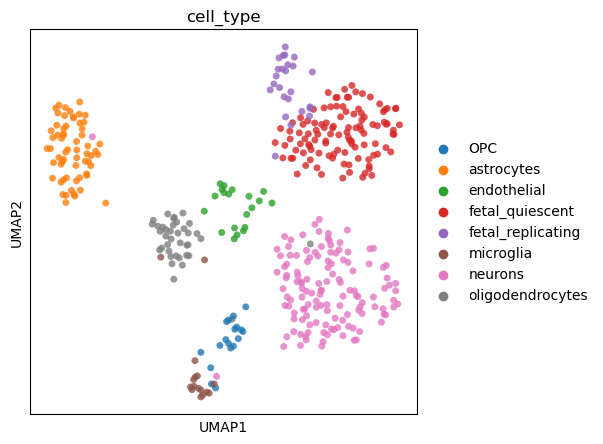

In [23]:
# display a UMAP plot
plt.figure(figsize=(5, 5))
sc.pl.umap(adata, color='cell_type', size=100, alpha=0.8, ax=plt.gca())

## Analysis using scikit-bio

Let's take a quick look at what scikit-bio can do.

In [24]:
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

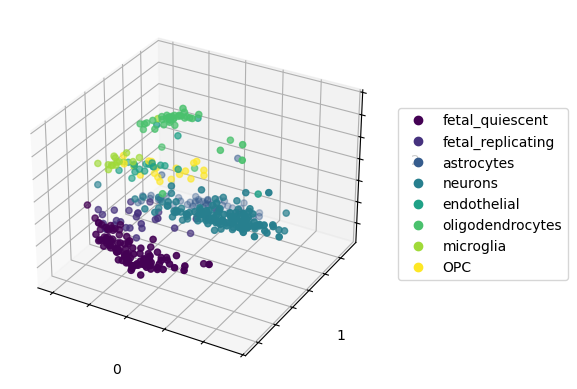

In [25]:
dm = beta_diversity('euclidean', adata)
res = pcoa(dm)
res.plot(ct, 'cell_type');

Note that the `beta_diversity` function can directly take an AnnData object as input, without the need for explicit format conversion.

## PCoA

Here, [**beta diversity**](https://en.wikipedia.org/wiki/Beta_diversity) is a community ecology term that quantifies the difference in species composition between two habitats. Mathematically, it is the pairwise distance / dissimilarity between two vectors. Applying scikit-bio's [`beta_diversity`](https://scikit.bio/docs/dev/generated/skbio.diversity.beta_diversity.html) function on a data table creates a [`DistanceMatrix`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.DistanceMatrix.html) among samples (cells).

In [26]:
dm

In [27]:
dm.data[:5, :5].round(3)

array([[  0.   , 239.562, 237.143, 238.04 , 237.263],
       [239.562,   0.   , 211.825, 225.502, 228.933],
       [237.143, 211.825,   0.   , 220.692, 226.631],
       [238.04 , 225.502, 220.692,   0.   , 234.995],
       [237.263, 228.933, 226.631, 234.995,   0.   ]])

Principal Coordinates Analysis ([**PCoA**](https://en.wikipedia.org/wiki/Multidimensional_scaling#Types)) is a multidimensional scaling technique that takes a distance/dissimilarity matrix as input and embed it in a lower-dimensional latent space. The output of scikit-bio's [`pcoa`](https://scikit.bio/docs/dev/generated/skbio.stats.ordination.pcoa.html) function stores the transformed coordinates of samples (cells).

In [28]:
res.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420
GSM1658365,12.602244,-49.558161,-15.964825,-23.285372,-2.844283,4.974195,-14.474087,0.868653,-5.001547,-4.704223,...,-2.281095,-0.471762,2.251389,2.715363,0.566438,-0.142530,0.066460,1.644797,-0.835491,-0.0
GSM1658366,-54.095594,-45.783211,-13.490736,2.837646,-4.454101,5.732183,4.325266,3.944510,-3.859265,0.477735,...,-2.091199,3.398606,3.531090,0.700709,1.975726,0.723615,-2.189156,2.561818,2.068592,-0.0
GSM1658364,-59.198665,-48.282408,-7.830123,15.573788,-2.690056,24.745941,-9.376781,1.514617,-8.589498,1.036344,...,-3.763863,-0.872299,4.444871,-1.602644,2.574192,1.656640,0.756938,-0.067878,-2.028381,-0.0
GSM1658363,-28.772414,-50.787282,-15.746498,-10.382034,-1.735047,6.966155,-6.303355,7.305748,1.560784,-7.771057,...,-2.683874,3.487659,-2.307461,1.015260,-1.213087,-1.818576,1.025267,0.570380,-0.140482,-0.0
GSM1658362,-11.387638,-47.095201,-10.927210,-5.282668,-9.986953,11.095011,-23.691745,-6.813759,-10.969610,-2.688495,...,0.471693,6.255471,-3.931127,0.494463,-0.104570,2.108827,-3.053274,2.696521,0.451484,-0.0


PCoA on a Euclidean distance matrix is equivalent to PCA. However, biological data rarely reflect pure Euclidean relationships. PCoA grants the flexibility of specifying alternative pairwise distance metrics. The following code uses the [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity) instead, and customizes the plot.

In [29]:
dm = beta_diversity('cosine', adata)

In [30]:
res = pcoa(dm)

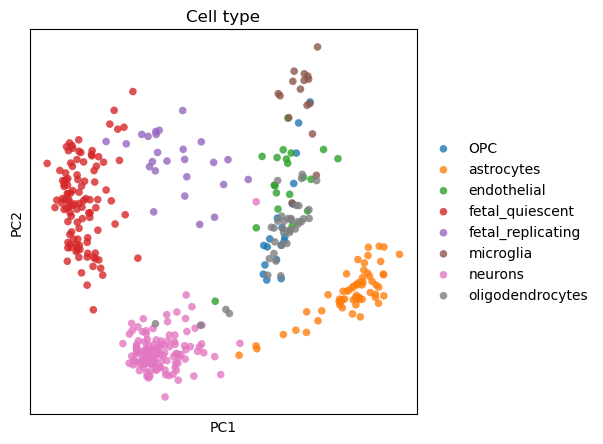

In [31]:
plt.figure(figsize=(5, 5))
for name, group in ct.groupby('cell_type'):
    plt.scatter('PC1', 'PC2', data=res.samples.loc[group.index], label=name,
                s=30, ec='none', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
plt.title('Cell type');

There are distance metrics specifically designed for single-cell data. For example, [**CIDR**](https://github.com/VCCRI/CIDR) (Clustering through Imputation and Dimensionality Reduction) ([Lin et al., 2017](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1188-0)) infers a dissimilarity matrix between cells based on dropout probability distributions.

We have pre-computed a dissimilarity matrix of the brain dataset using the R package [CIDR](https://github.com/VCCRI/CIDR). Now, we will load it into a scikit-bio DistanceMatrix object.

In [32]:
from skbio.stats.distance import DistanceMatrix

In [33]:
dm = DistanceMatrix.read('cidr.csv')
dm.shape

(420, 420)

In [34]:
dm.data[:5, :5].round(3)

array([[  0.   , 249.768, 249.92 , 247.194, 243.47 ],
       [249.768,   0.   , 256.257, 261.974, 260.475],
       [249.92 , 256.257,   0.   , 252.859, 261.241],
       [247.194, 261.974, 252.859,   0.   , 263.523],
       [243.47 , 260.475, 261.241, 263.523,   0.   ]])

Perform PCoA and plot the outcome.

In [35]:
res = pcoa(dm)

/home/drz/Conda/envs/skbio-070/lib/python3.13/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -151428.62525590335 whereas the largest positive one is 881396.0735423472.
  warn(


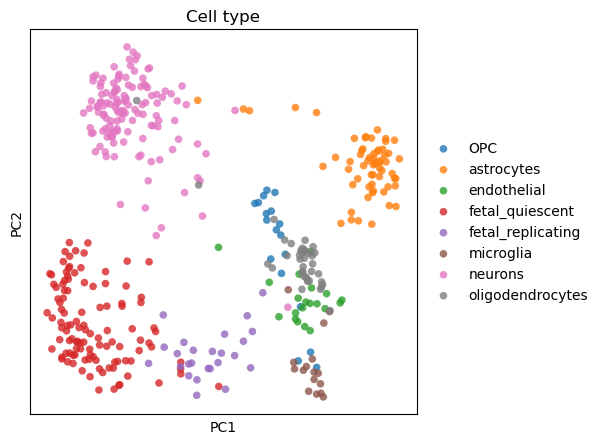

In [36]:
plt.figure(figsize=(5, 5))
for name, group in ct.groupby('cell_type'):
    plt.scatter('PC1', 'PC2', data=res.samples.loc[group.index], label=name,
                s=30, ec='none', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])
plt.title('Cell type');

As can be seen above, the PCoA plot reveals clear distinction between cell types. This separation indicates that the underlying dissimilarity matrix effectively captures biologically meaningful variation, and the cell type differences is directly reflected in the PCoA plot since decomposes distances into orthogonal axes that maximize explained variance.

## PERMANOVA

In addition to visual patterns, we want to obtain statistical evidence for the differential gene expression profiles between cell types. This can be achieved with Permutational Multivariate Analysis of Variance ([**PERMANOVA**](https://en.wikipedia.org/wiki/Permutational_analysis_of_variance)) ([Anderson, 2008](https://onlinelibrary.wiley.com/doi/10.1111/j.1442-9993.2001.01070.pp.x)), implemented in scikit-bio's [`permanova`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.permanova.html) function.

PERMANOVA takes a distance/dissimilarity matrix and group labels (here cell types) as input, and tests whether the groups' centroids and dispersions in the hyperdimensional space (analogous to means and variances in ANOVA) are different from each other.

In [37]:
from skbio.stats.distance import permanova

In [38]:
permanova(dm, ct['cell_type'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     420
number of groups                  8
test statistic            11.855093
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

The PERMANOVA result shown above suggested a significant difference among the gene expression profiles of the eight cell types.

- Here, the pseudo‑*F* statistic (analogous to the ANOVA *F*-statistic) is a effect size metric that quantifies how much of the total dissimilarity among samples is explained by group differences versus within-group variability. An *F* = 11.8 indicates that the variance between cell types is more than 10x greater than the variance within the same cell type.

- To assess significance, PERMANOVA performs a permutation test: it randomly shuffles group labels 999 times as show in the results and calculates the pseudo‑*F* for each permuted dataset. This builds a null distribution of pseudo‑*F* values. The *p*‑value is then the proportion of permutations where the permuted pseudo‑*F* is at least as large as the observed value. *p*‑value that is less than a pre-defined threshold (e.g., 0.05) indicates that the group structure is statistically significant.

Knowing that there is overall difference among cell types, we can further perform _post hoc_ analyses to test the difference between any pair of cell types.

In [39]:
ct_pair = ct.query('cell_type == ["neurons", "fetal_quiescent"]')

In [40]:
dm_pair = dm.filter(ct_pair.index)

In [41]:
permanova(dm_pair, ct_pair['cell_type'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     241
number of groups                  2
test statistic            16.538107
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

We can do this between all pairs of cell types. Scikit-bio's [`DissimilarityMatrix`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.DissimilarityMatrix.html) (or `DistanceMatrix`) class has a convenient method `from_iterable` to run a function between each pair of objects and construct a matrix.

- Note: The difference between the two classes is that a `DistanceMatrix` must be symmetric and hollow (diagonal = 0), whereas `DissimilarityMatrix` doesn't have these limitations.

In [42]:
from operator import itemgetter
from skbio.stats.distance import DissimilarityMatrix

In [43]:
def permanova_f(a, b):
    if a[0] == b[0]:
        return 0.0
    idx = a[1].index.union(b[1].index)
    res = permanova(dm.filter(idx), ct.loc[idx, 'cell_type'])
    return res['test statistic']

In [44]:
fmat = DissimilarityMatrix.from_iterable(list(ct.groupby('cell_type')), permanova_f, itemgetter(0))

In [45]:
fmat.data.round(3)

array([[ 0.   ,  6.757,  4.309,  7.169,  4.194,  3.979,  7.761,  5.804],
       [ 6.757,  0.   ,  8.757, 23.851,  9.343,  9.703, 23.686, 15.471],
       [ 4.309,  8.757,  0.   ,  9.42 ,  4.778,  3.847, 10.974,  7.157],
       [ 7.169, 23.851,  9.42 ,  0.   ,  4.877,  9.126, 16.538, 16.431],
       [ 4.194,  9.343,  4.778,  4.877,  0.   ,  5.379, 10.582,  8.72 ],
       [ 3.979,  9.703,  3.847,  9.126,  5.379,  0.   , 12.213,  8.068],
       [ 7.761, 23.686, 10.974, 16.538, 10.582, 12.213,  0.   , 17.682],
       [ 5.804, 15.471,  7.157, 16.431,  8.72 ,  8.068, 17.682,  0.   ]])

Plot a heat map of pseudo-*F* values. The plot clearly reveals the relationships between cell types. For example, it shows that astrocytes has a high dissimilarity with two most abundant cell types: neurons and fetal quiescent.

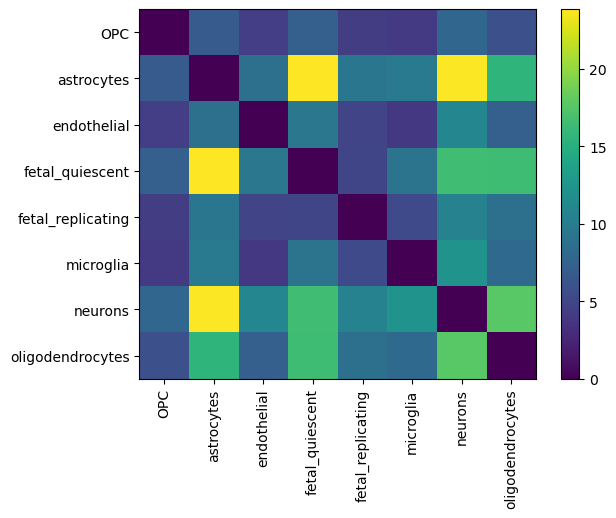

In [46]:
fmat.plot();

We can also modify the function to let it return *p*-value instead pseudo-*F*. However, don't forget to perform [multiple comparison correction](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) after getting the *p*-values!

scikit-bio implements three statistical tests for the difference between sample groups. The other two are [`anosim`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.anosim.html) (Analysis of Similarities), [`permdisp`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.permdisp.html) (Test for Homogeneity of Multivariate Groups Disperisons).

## Dirmult t-test

Knowing that gene expression profiles differ by cell type, we will next identify specific genes that are differentially expressed between cell types. This can be achieved using [differential gene expression](https://en.wikipedia.org/wiki/Gene_expression_profiling) (**DGE**) analysis.

Below, we will analyze **neurons** and **fetal quiescent cells**, the two cell types representing the most abundant populations in the dataset. Fetal quiescent cells are a type of non-dividing, resting phase of neural stem cells. It will be interesting to examine the differential gene expression versus mature neurons.

To save time during this tutorial, we will limit the analysis to the 2000 highly variable genes identified by Scanpy.

Scanpy's `rank_genes_groups` function implements several basic statistical tests for DGE analysis. The following code performs the [Wilcoxon rank-sum test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test), a simple non-parametric statistical test on the normalized, log-transformed data.

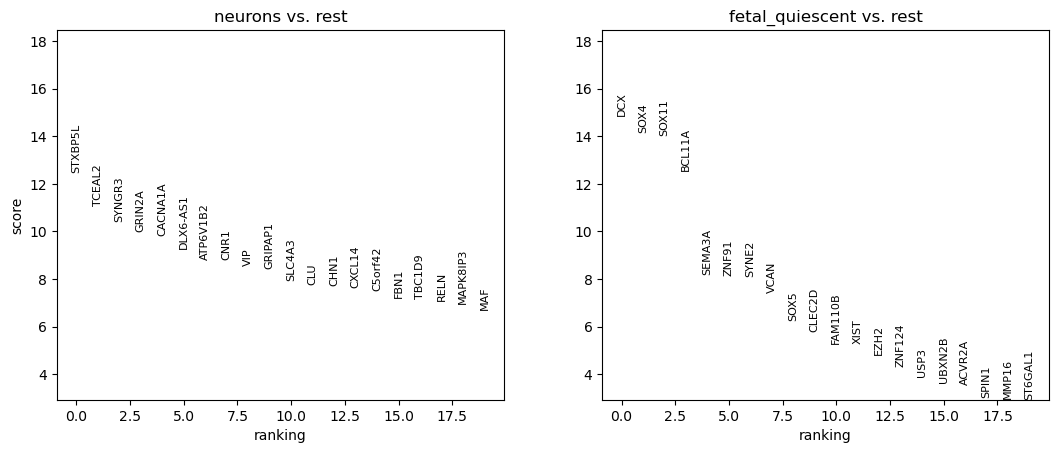

In [47]:
sc.tl.rank_genes_groups(adata, 'cell_type', groups=['neurons', 'fetal_quiescent'],
                        mask_var='highly_variable', method='wilcoxon')
sc.pl.rank_genes_groups(adata)

Scikit-bio, on the other hand, features a comprehensive suite of [**compositional data**](https://en.wikipedia.org/wiki/Compositional_data) analysis utilities in its [`composition`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.html) module. This includes various arithmetic operations, transformation methods, as well differential abundance (**DA**; mathematically equivalent to DGE) methods.

**Compositionality**, in brief, is a mathematical property that data points are proportions instead of absolute abundance. Many omics data types are inherently compositional ([Quinn et al., 2018](https://academic.oup.com/bioinformatics/article/34/16/2870/4956011)), such as microbiome data and bulk RNA-seq data, as well as scRNA-seq data ([Büttner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6)). Because the total read count (abundance) of a sample is capped by the sequencing depth, higher abundance of a specific feature inevitably leads to lower abundance of all other features in the same sample. This inter-dependency of feature abundances complicates data analysis, and requires a different mathematical framework, namely [**Aitchison geometry**](https://en.wikipedia.org/wiki/Compositional_data#Aitchison_geometry).

- A more comprehensive introduction to compositional data analysis can be found in: [Section 05: Inferring and associating critical features](https://colab.research.google.com/github/scikit-bio/scikit-bio-tutorials/blob/main/05-marker-inference/05-marker-inference.ipynb).

Below, we will use the [`dirmult_ttest`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.dirmult_ttest.html) function to perform the DGE analysis. This is a Python re-implementation of the method underlying the R package [**ALDEx2**](https://www.bioconductor.org/packages/devel/bioc/vignettes/ALDEx2/inst/doc/ALDEx2_vignette.html) ([Fernandes et al., 2014](https://microbiomejournal.biomedcentral.com/articles/10.1186/2049-2618-2-15)), originally designed for microbiome and bulk RNA-seq data analysis.

In [48]:
from skbio.stats.composition import dirmult_ttest

Filter the original count matrix with the 2000 highly variable genes. Note that `dirmult_ttest` takes raw counts as input, instead of normarlized and/or transformed data.

In [49]:
hvg = adata.var.highly_variable
df_hvg = df[hvg[hvg].index]
df_hvg.shape

(420, 2000)

Further filter the count matrix to neurons and fetal quiescent cells.

In [50]:
df_pair = df_hvg.loc[ct_pair.index]
df_pair.shape

(241, 2000)

Run `dirmult_ttest`. In brief, the underlying procedures are:

1. Re-sample data from a Dirichlet multinomial posterior distribution.
2. Perform [center log ratio](https://en.wikipedia.org/wiki/Compositional_data#Center_log_ratio_transform) (**CLR**) transformation on the resampled data. (CLR alone is available via the [`clr`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.clr.html) function.)
3. Perform Welch's *t*-test to assess the significance of differential group mean per feature (gene).
4. Repeat this process for a large number of times and report the mean.

In [51]:
res = dirmult_ttest(df_pair, ct_pair['cell_type'], treatment='neurons', reference='fetal_quiescent', seed=42)

For each gene, the result reports the log<sub>2</sub> fold change (FC) of the estimated expression level from reference (fetal quiescent cells) to treatment (neurons), and the 95% confidence interval (CI) of this estimate. It further reports the *t*-statistic, the *p*-value, and the multiple comparison corrected *p*-value (*q*-value).

In [52]:
res.head()

,T-statistic,Log2(FC),CI(2.5),CI(97.5),pvalue,qvalue,Signif
A1CF,-1.384817,-0.584833,-2.991767,1.360028,0.266789,1.0,False
A2M,1.102002,0.553261,-1.389992,2.707471,0.342229,1.0,False
AADAT,1.207393,0.679738,-1.231719,2.590868,0.299553,1.0,False
ABCA4,-1.029031,-0.432705,-2.625840,1.697866,0.353821,1.0,False
ABCA6,4.083309,2.017550,0.259796,3.935414,0.000802,1.0,False


A total of 55 genes were considered as significantly differentially expressed.

In [53]:
res['Signif'].value_counts()

Signif
False    1945
True       55
Name: count, dtype: int64

Preview the significantly differentially expressed genes. We see genes involved in neural progenitor differentiation, migration, and lineage specification, which appear to make biological sense.

In [54]:
mask = res['Signif']
res[mask].sort_values('Log2(FC)').iloc[:, :-1].head(10)

,T-statistic,Log2(FC),CI(2.5),CI(97.5),pvalue,qvalue
SOX11,-20.327691,-9.333456,-10.889377,-8.137060,1.410776e-41,2.820141e-38
SOX4,-18.191524,-8.112364,-9.425665,-6.948818,3.715449e-37,7.423467e-34
DCX,-17.429415,-7.712533,-9.112871,-6.558691,8.044534e-36,1.606493e-32
BCL11A,-11.794174,-6.956995,-8.800803,-5.297361,5.183990e-22,1.034724e-18
VCAN,-8.750460,-5.715612,-7.709699,-3.602195,6.711138e-14,1.332832e-10
SYNE2,-9.540401,-5.699177,-7.725528,-3.712985,1.489305e-14,2.959249e-11
SEMA3A,-8.278351,-5.345226,-7.307664,-3.357845,8.876925e-12,1.756743e-08
SOX5,-6.287619,-3.927307,-5.837009,-2.008249,4.217107e-08,8.290832e-05
EZH2,-5.146210,-2.879781,-5.015639,-0.873186,2.124752e-05,4.139016e-02
CLEC2D,-5.211047,-2.340310,-3.988572,-0.815442,1.085347e-05,2.118598e-02


Make a volcano plot to visualize the effect size and statstical significance of the identified genes.

In [55]:
res['pvalue_log10'] = -np.log10(res['pvalue'])

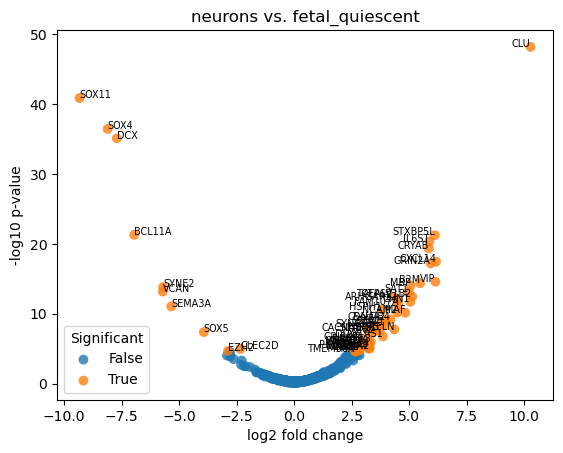

In [56]:
plt.figure()
plt.scatter('Log2(FC)', 'pvalue_log10', data=res[~mask], s=50, alpha=0.8, ec='none', label='False')
plt.scatter('Log2(FC)', 'pvalue_log10', data=res[mask], s=50, alpha=0.8, ec='none', label='True')
for gene, row in res[mask].iterrows():
    ha = 'right' if row['Log2(FC)'] > 0 else 'left'
    plt.text(row['Log2(FC)'], row['pvalue_log10'], gene, ha=ha, fontsize='x-small')
plt.xlabel('log2 fold change')
plt.ylabel('-log10 p-value')
plt.legend(title='Significant')
plt.title('neurons vs. fetal_quiescent');

Comparing with the genes identified by Wilcoxon rank-sum test, we can see multiple genes shared by both results, whereas each method provides some unique insights.

In addition to `dirmult_ttest`, scikit-bio also implements [`dirmult_lme`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.dirmult_lme.html) for longitudinal DGE analysis, as well as [`ancom`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.ancom.html), which identifies genes that are up/down-regulated vs. all other genes.

## Mantel test

Next, we will assess the correlation between gene expression profiles of different cell types using an alternative method: Mantel test ([`mantel`](https://scikit.bio/docs/dev/generated/skbio.stats.distance.mantel.html)).

[**Mantel test**](https://en.wikipedia.org/wiki/Mantel_test) ([Mantel, 1967](https://aacrjournals.org/cancerres/article/27/2_Part_1/209/476508/The-Detection-of-Disease-Clustering-and-a)) is a multivariate statistical test that resembles PERMANOVA is several ways (such as random permutation). Instead of relating a distance matrix and a categorical variable, Mantel test relates two distance matrices. It is typically used in [multi-omics](https://en.wikipedia.org/wiki/Multiomics) to assess the consistency between omic layers. Here, we will use it to assess the correlation of gene expression profiles between cell types.

In [57]:
from skbio.stats.distance import mantel

To make that happen, we first need to construct a matrix representing the pairwise dissimilarity between genes (not cells). We will use scikit-bio's [`pairwise_vlr`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.pairwise_vlr.html) function, which calculates the pairwise variance log ratio (**VLR**) ([Lovell et al., 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004075)). This metric quantifies the relative abundance of each gene versus every other gene in the logarithm space, thereby complying with the compositional nature of the data.

In [58]:
from skbio.stats.composition import pairwise_vlr

Because logarithm cannot be applied to zeros, we need to first process the count matrix such that all values are strictly positive. This can be achieved with adding a small **pseudocount** (such as 1, as in Scanpy's `log1p`) to all cell values. A more robust and adaptive alternative is **multiplicative replacement** ([Martín-Fernández et al., 2003](https://link.springer.com/article/10.1023/a:1023866030544)), implemented in the [`multi_replace`](https://scikit.bio/docs/dev/generated/skbio.stats.composition.multi_replace.html) function.

In [59]:
from skbio.stats.composition import multi_replace

Now that we have all three necessary scikit-bio functions imported, we can perform the analysis.

Perform multiplicative replacement on each row (cell).

In [60]:
df_mr = df_hvg.apply(multi_replace, axis=1, result_type='expand')
df_mr.columns = df_hvg.columns

Stratify the transformed data matrix by cell type and calculate variance log ratios. This will result in a 2000 x 2000 distance matrix per cell type.

In [61]:
dm_vlrs = {name: pairwise_vlr(df_) for name, df_ in df_mr.groupby(ct['cell_type'])}

In [62]:
dm_vlrs['neurons'].shape

(2000, 2000)

Perform Mantel test to calculate the correlation between neurons and fetal quiescent cells. The three values in the output are Pearson's correlation coefficient (*r*), *p*-value, and sample size. As we see, *r* ~= 0.75, indicating a moderate to strong correlation.

In [63]:
neuron_vs_fetqui = mantel(dm_vlrs['neurons'], dm_vlrs['fetal_quiescent'])
neuron_vs_fetqui

(np.float64(0.7540740263119231), np.float64(0.001), 2000)

Also perform Mantel test to calculate the correlation between astrocytes and the two former cell types. The correlation coefficients are lower than that above, suggesting that astrocytes' gene expression profile less well resembles the other two cell types. This pattern is consistent with the previously generated UMAP plot and the PERMANOVA test results.

In [64]:
astro_vs_neuron = mantel(dm_vlrs['astrocytes'], dm_vlrs['neurons'])
astro_vs_neuron

(np.float64(0.7121329775301694), np.float64(0.001), 2000)

In [65]:
astro_vs_fetqui = mantel(dm_vlrs['astrocytes'], dm_vlrs['fetal_quiescent'])
astro_vs_fetqui

(np.float64(0.6350899302329658), np.float64(0.001), 2000)

## Final thoughts

This tutorial has highlighted key features of scikit-bio related to distance matrix operations and compositional data analysis. We're not suggesting that scikit-bio *should* be the default choice for single-cell data analysis; rather, our goal is to demonstrate how its versatile tools can be applied across a range of research tasks, including but not limited to single-cell studies. Ultimately, scikit-bio is a general-purpose library, not a specialized pipeline. We encourage you to explore its functionality and integrate the components that best complement your own workflows.